# Algoritmo de Deutsch-Jozsa em Qiskit

José Carlos de Oliveira Júnior

2 de dezembro de 2019

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

from qiskit.tools.visualization import plot_histogram

## Circuito

O algoritmo de Deutsch-Jozsa é usado para verificar se uma função $f:\{0,1\}^n \mapsto \{0,1\}$ é balanceada ou constantes. São necessários $n+1$ qubits para executar o algoritmo, sendo $n$ o número de bits de entrada da função.

Para este trabalho, usaremos uma função que usa $3$ bits de entrada, tendo um domínio de tamanho $8$. Portanto, usaremos $4$ qubits.

In [2]:
n = 3

Usando o Qiskit, vamos iniciar o circuito quântico. Além dos $n$ qubits, vamos precisar de um registrador clássico de tamanho $n$ para armazenar a resposta do algoritmo. O significado da resposta será explicado mais a frente.

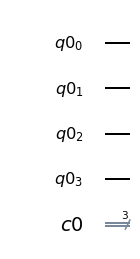

In [3]:
qr = QuantumRegister(n + 1)
cr = ClassicalRegister(n)

djCircuit = QuantumCircuit(qr, cr)

djCircuit.draw(output='mpl')

Todos os primeiros $n$ qubits devem ser inicializados com $0$ e o último deve ser inicializado com $1$. O Qiskit já inicializa os qubits com $0$, então vamos usar a porta $X$ para mudar o último.

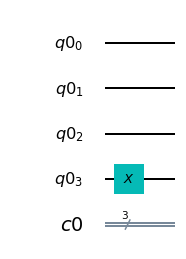

In [4]:
djCircuit.x(qr[n])

djCircuit.draw(output='mpl')

O próximo passo do circuito é aplicar a porta Hadamard em todos os qubits para sobrepor todos os estados possíveis.

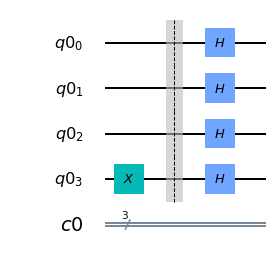

In [5]:
djCircuit.barrier()

djCircuit.h(qr)

djCircuit.draw(output='mpl')

Agora, aqui entra a função que devemos verificar se é balanceada ou constante. Um oráculo é um operador que é utilizado para avaliar a saída da função. Tratamos-a como uma caixa-preta, não sendo necessário entender sua implementação. Diante disto, simulamos um oráculo que com o código abaixo.

Definimos uma variável `oracle` que define se a função é balanceada ou constante. Dependendo da função escolhida, CNOT aleatórios são usados para simular o oráculo.

In [6]:
oracle = "b"

In [7]:
if oracle == "b":
    b = np.random.randint(1,2**n)

if oracle == "c":
    c = np.random.randint(2)

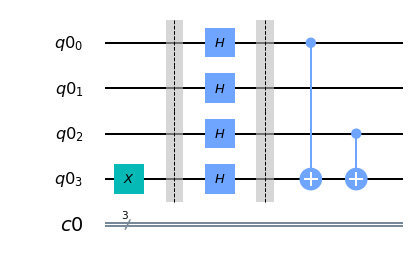

In [8]:
djCircuit.barrier()

if oracle == "c":
    if c == 1:
        djCircuit.x(qr[n])
    else:
        djCircuit.iden(qr[n])
else:
    for i in range(n):
        if (b & (1 << i)):
            djCircuit.cx(qr[i], qr[n])
            
djCircuit.draw(output='mpl')

Aplicamos Hadamard nos $n$ primeiros qubits.

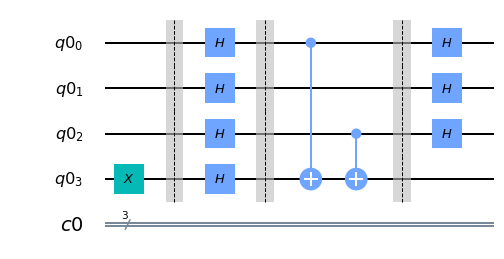

In [9]:
djCircuit.barrier()

for i in range(n):
    djCircuit.h(qr[i])

djCircuit.draw(output='mpl')

E medimos o primeiro registrador. Se o medirmos $\left|0\cdots 0\right\rangle$, então a função é constante. Senão, então é balanceada.

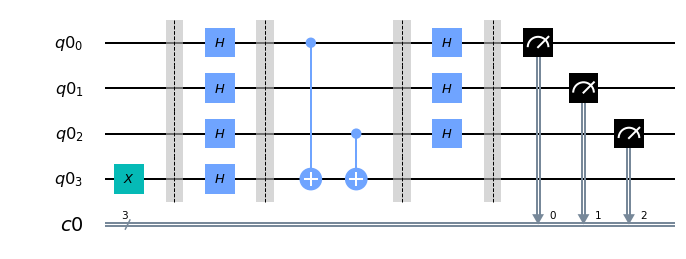

In [10]:
djCircuit.barrier()

for i in range(n):
    djCircuit.measure(qr[i], cr[i])
    
djCircuit.draw(output='mpl')

## Simulação no Computador Clássico

Abaixo a simulação em computador clássico para uma função balanceada com 1024 experimentos.

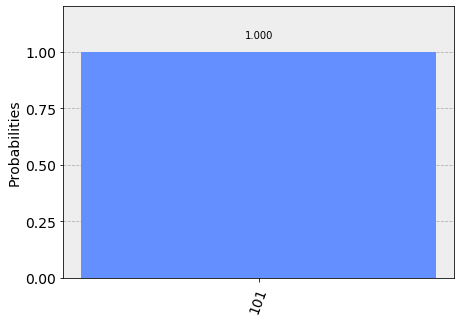

In [11]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(djCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

## Simulação em IBM Q

Abaixo a simulação no IBM Q para uma função balanceada com 1024 experimentos.

In [18]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


least busy backend:  ibmq_ourense


In [19]:
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(djCircuit, backend=backend, shots=shots)

job_monitor(job, interval = 2)

Job Status: job has successfully run


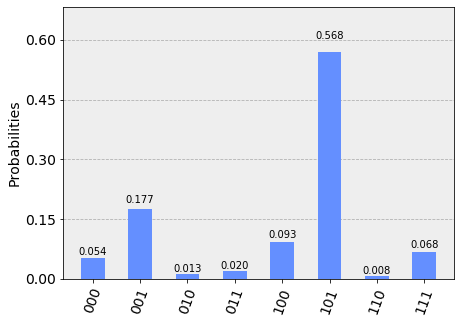

In [20]:
results = job.result()
answer = results.get_counts()

plot_histogram(answer)